**Library Imports**:

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.cluster import DBSCAN

In [61]:
#set panda options to max display to view all columns:
pd.options.display.max_columns = None

## Problem Statement:

Can we use (socioeconomic, demographic, and employment data) to cluster states with higher risk of being affected by a pandemic to allot resources to those areas for future disproportionate effect mitigation?

## Data Cleaning & Merging:

**Data Imports:** Let's read in the socioeconomic determinants data along with the corresponding rolling aggregates for year end covid statistics:

In [70]:
df = pd.read_csv('data/Socioeconomic Data/Socioeconomic determinants/socioeconomic determinant for state.csv')
df_2 = pd.read_csv('data/csse_covid_19_daily_reports_us/12-31-2020.csv')
unemp_covid_df = pd.read_csv('data/yun_data/output/unemployment_covid_2020.csv')
covid_df = pd.read_csv('data/yun_data/output/covid_monthly_2020.csv')
df3 = pd.read_csv('data/yun_data/output/unemp_rate_2020.csv')
df4 = pd.read_csv('data/yun_data/output/cov_unemp_summary.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/yun_data/output/unemp_rate_2020.csv'

In [63]:
#familiarize ourselves with each respective dataframes with .head(), also print out df shape to see how we'd like to merge
print(df.shape)
df.head()

(51, 26)


,FIPS,Name,Postal Code,Area size,Population size,Population density,Senior Population,Young Population,Male Population,White Population,Africa-American Population,Hispanic population,Internet access,High school degree,Bachelor degrees,Median household income,Poverty rate,Uninsured,Household size,House Owner,hospital,hospital bed,ICU bed,ventilator usage,Nurses,Medical Doctors
0,1,Alabama,AL,135767,4903185,36.114704,17.4,18.3,48.3,69.5,27.8,4.5,81.9,12.9,16.3,51734,15.5,9.7,2.60,68.8,119,18611,1637,383,85746,43429
1,2,Alaska,AK,1723337,731545,0.424493,12.4,21.0,52.0,71.4,4.7,7.2,88.0,6.4,18.5,75463,10.1,12.2,2.90,64.7,28,1832,193,41,15487,18418
2,4,Arizona,AZ,295234,7278717,24.654061,18.0,18.7,49.7,81.7,6.0,31.7,87.4,12.4,18.8,62055,13.5,11.3,2.71,65.3,125,18388,1882,427,93928,84130
3,5,Arkansas,AR,137732,3017804,21.910696,17.4,19.2,48.9,79.3,16.7,7.7,80.1,12.5,15.1,48952,16.2,9.1,2.59,65.5,105,12473,914,261,42487,47343
4,6,California,CA,423967,39512223,93.196459,14.8,18.7,49.7,63.6,7.0,39.4,90.0,16.0,21.9,80440,11.8,7.7,3.02,54.9,461,80893,8652,1986,444964,588052


In [64]:
#same as above for our second dataframe:
print(df_2.shape)
df_2.head()

(58, 18)


,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2021-01-01 05:30:27,32.3182,-86.9023,361226,4827,202137.0,154262.0,1.0,7367.170523,1874000.0,NaN,1.336283,84000001.0,USA,38220.054923,NaN
1,Alaska,US,2021-01-01 05:30:27,61.3707,-152.4044,46986,206,7165.0,39615.0,2.0,6422.844801,1275750.0,NaN,0.438428,84000002.0,USA,174391.185778,NaN
2,American Samoa,US,2021-01-01 05:30:27,-14.2710,-170.1320,0,0,NaN,0.0,60.0,0.000000,2140.0,NaN,NaN,16.0,ASM,3846.084722,NaN
3,Arizona,US,2021-01-01 05:30:27,33.7298,-111.4312,520207,8864,75981.0,435362.0,4.0,7146.960103,2834752.0,NaN,1.703937,84000004.0,USA,38945.764755,NaN
4,Arkansas,US,2021-01-01 05:30:27,34.9697,-92.3731,225138,3676,199247.0,22215.0,5.0,7460.325455,2051488.0,NaN,1.632776,84000005.0,USA,67979.497674,NaN


As we can see from the shapes, there are more rows in our second dataframe compared to our first dataframe. This is likely a result of the second dataset including additional US terrorities (which is shown via the inclusion of "American Samoa"). These differences could pose an issue when trying to simply concatenate our frames since the corresponding data won't line up. A easy solution is to utilize the inner join method, which will combine the two dataframes on a similar column but will only bond the frames that have entries for the corresponding columns we've elected to join on. So since our first df doesn't include these territories, our merged frame will not have them either and we should simply see a final merged df with 51 rows (50 states + Washington DC). To join via states we will have to indicate which columns that is for each respective df ('Name' & 'Province_State'):

In [65]:
dmf=df.merge(df_2, left_on='Name', right_on='Province_State')
print(dmf.shape)
dmf.head()

(51, 44)


,FIPS_x,Name,Postal Code,Area size,Population size,Population density,Senior Population,Young Population,Male Population,White Population,Africa-American Population,Hispanic population,Internet access,High school degree,Bachelor degrees,Median household income,Poverty rate,Uninsured,Household size,House Owner,hospital,hospital bed,ICU bed,ventilator usage,Nurses,Medical Doctors,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS_y,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,1,Alabama,AL,135767,4903185,36.114704,17.4,18.3,48.3,69.5,27.8,4.5,81.9,12.9,16.3,51734,15.5,9.7,2.60,68.8,119,18611,1637,383,85746,43429,Alabama,US,2021-01-01 05:30:27,32.3182,-86.9023,361226,4827,202137.0,154262.0,1.0,7367.170523,1874000.0,NaN,1.336283,84000001.0,USA,38220.054923,NaN
1,2,Alaska,AK,1723337,731545,0.424493,12.4,21.0,52.0,71.4,4.7,7.2,88.0,6.4,18.5,75463,10.1,12.2,2.90,64.7,28,1832,193,41,15487,18418,Alaska,US,2021-01-01 05:30:27,61.3707,-152.4044,46986,206,7165.0,39615.0,2.0,6422.844801,1275750.0,NaN,0.438428,84000002.0,USA,174391.185778,NaN
2,4,Arizona,AZ,295234,7278717,24.654061,18.0,18.7,49.7,81.7,6.0,31.7,87.4,12.4,18.8,62055,13.5,11.3,2.71,65.3,125,18388,1882,427,93928,84130,Arizona,US,2021-01-01 05:30:27,33.7298,-111.4312,520207,8864,75981.0,435362.0,4.0,7146.960103,2834752.0,NaN,1.703937,84000004.0,USA,38945.764755,NaN
3,5,Arkansas,AR,137732,3017804,21.910696,17.4,19.2,48.9,79.3,16.7,7.7,80.1,12.5,15.1,48952,16.2,9.1,2.59,65.5,105,12473,914,261,42487,47343,Arkansas,US,2021-01-01 05:30:27,34.9697,-92.3731,225138,3676,199247.0,22215.0,5.0,7460.325455,2051488.0,NaN,1.632776,84000005.0,USA,67979.497674,NaN
4,6,California,CA,423967,39512223,93.196459,14.8,18.7,49.7,63.6,7.0,39.4,90.0,16.0,21.9,80440,11.8,7.7,3.02,54.9,461,80893,8652,1986,444964,588052,California,US,2021-01-01 05:30:27,36.1162,-119.6816,2325599,25986,NaN,2265110.0,6.0,5798.223502,32855482.0,NaN,1.130376,84000006.0,USA,83152.704418,NaN


**51 rows with 44 columns. We have successfully merged our sets into one combined dataframe.**

Now let's check for any nulls:

In [66]:
dmf.isnull().sum()

FIPS_x                         0
Name                           0
Postal Code                    0
Area size                      0
Population size                0
Population density             0
Senior Population              0
Young Population               0
Male Population                0
White Population               0
Africa-American Population     0
Hispanic population            0
Internet access                0
High school degree             0
Bachelor degrees               0
Median household income        0
Poverty rate                   0
Uninsured                      0
Household size                 0
House Owner                    0
hospital                       0
hospital bed                   0
ICU bed                        0
ventilator usage               0
Nurses                         0
Medical Doctors                0
Province_State                 0
Country_Region                 0
Last_Update                    0
Lat                            0
Long_     

From above we can see that th entire People_Hospitalized and Hospitalization_Rate are null for the entire set. Since we cannot impute or calculate these metrics within reason, we can simply drop these columns. While we are at it, we can also drop any additional columns that we won't need for EDA and modeling purposes that will clutter up our dataframe.

In [67]:
# Drop unnecessary columns
dmf.drop(columns = ['FIPS_x','Province_State','Country_Region',
                    'Last_Update','Lat','Long_','FIPS_y','People_Hospitalized',
                    'UID','ISO3','Hospitalization_Rate'], inplace = True)

In [68]:
print(dmf.shape)
dmf.head()

(51, 33)


,Name,Postal Code,Area size,Population size,Population density,Senior Population,Young Population,Male Population,White Population,Africa-American Population,Hispanic population,Internet access,High school degree,Bachelor degrees,Median household income,Poverty rate,Uninsured,Household size,House Owner,hospital,hospital bed,ICU bed,ventilator usage,Nurses,Medical Doctors,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate
0,Alabama,AL,135767,4903185,36.114704,17.4,18.3,48.3,69.5,27.8,4.5,81.9,12.9,16.3,51734,15.5,9.7,2.60,68.8,119,18611,1637,383,85746,43429,361226,4827,202137.0,154262.0,7367.170523,1874000.0,1.336283,38220.054923
1,Alaska,AK,1723337,731545,0.424493,12.4,21.0,52.0,71.4,4.7,7.2,88.0,6.4,18.5,75463,10.1,12.2,2.90,64.7,28,1832,193,41,15487,18418,46986,206,7165.0,39615.0,6422.844801,1275750.0,0.438428,174391.185778
2,Arizona,AZ,295234,7278717,24.654061,18.0,18.7,49.7,81.7,6.0,31.7,87.4,12.4,18.8,62055,13.5,11.3,2.71,65.3,125,18388,1882,427,93928,84130,520207,8864,75981.0,435362.0,7146.960103,2834752.0,1.703937,38945.764755
3,Arkansas,AR,137732,3017804,21.910696,17.4,19.2,48.9,79.3,16.7,7.7,80.1,12.5,15.1,48952,16.2,9.1,2.59,65.5,105,12473,914,261,42487,47343,225138,3676,199247.0,22215.0,7460.325455,2051488.0,1.632776,67979.497674
4,California,CA,423967,39512223,93.196459,14.8,18.7,49.7,63.6,7.0,39.4,90.0,16.0,21.9,80440,11.8,7.7,3.02,54.9,461,80893,8652,1986,444964,588052,2325599,25986,NaN,2265110.0,5798.223502,32855482.0,1.130376,83152.704418


We also saw 7 nulls for the recovered column. This we ARE able to calculate with the given information. As we can deduce for the other entries, 'Recovered' metric is determined by 'Confirmed' cases subtracted by 'Deaths' then subtracted by 'Active'. Intuitively this makes sense so we can feel comfortable with this imputing method. 

Also it will be important to look at our covid metrics on a per capita basis otherwise our findings will certainly be less meaningful considering they will hold biases towards states with larger populations. So let's also add a few columns to our database by taking our interested metric and dividing it by corresponding state population size.

In [58]:
#imputing NaNs with intuation:
dmf['Recovered'] = dmf['Confirmed'] - dmf['Deaths'] - dmf['Active']

#creating per capita columns:
dmf['deaths_per_population'] = dmf['Deaths'] / dmf['Population size']
dmf['recovered_per_population'] = dmf['Recovered'] / dmf['Population size']
dmf['confirmed_per_population'] = dmf['Confirmed'] / dmf['Population size']
dmf['active_per_population'] = dmf['Active'] / dmf['Population size']
print(dmf.shape)
dmf.head()

(51, 37)


,Name,Postal Code,Area size,Population size,Population density,Senior Population,Young Population,Male Population,White Population,Africa-American Population,Hispanic population,Internet access,High school degree,Bachelor degrees,Median household income,Poverty rate,Uninsured,Household size,House Owner,hospital,hospital bed,ICU bed,ventilator usage,Nurses,Medical Doctors,Confirmed,Deaths,Recovered,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,deaths_per_population,recovered_per_population,confirmed_per_population,active_per_population
0,Alabama,AL,135767,4903185,36.114704,17.4,18.3,48.3,69.5,27.8,4.5,81.9,12.9,16.3,51734,15.5,9.7,2.60,68.8,119,18611,1637,383,85746,43429,361226,4827,202137.0,154262.0,7367.170523,1874000.0,1.336283,38220.054923,0.000984,0.041226,0.073672,0.031462
1,Alaska,AK,1723337,731545,0.424493,12.4,21.0,52.0,71.4,4.7,7.2,88.0,6.4,18.5,75463,10.1,12.2,2.90,64.7,28,1832,193,41,15487,18418,46986,206,7165.0,39615.0,6422.844801,1275750.0,0.438428,174391.185778,0.000282,0.009794,0.064228,0.054153
2,Arizona,AZ,295234,7278717,24.654061,18.0,18.7,49.7,81.7,6.0,31.7,87.4,12.4,18.8,62055,13.5,11.3,2.71,65.3,125,18388,1882,427,93928,84130,520207,8864,75981.0,435362.0,7146.960103,2834752.0,1.703937,38945.764755,0.001218,0.010439,0.071470,0.059813
3,Arkansas,AR,137732,3017804,21.910696,17.4,19.2,48.9,79.3,16.7,7.7,80.1,12.5,15.1,48952,16.2,9.1,2.59,65.5,105,12473,914,261,42487,47343,225138,3676,199247.0,22215.0,7460.325455,2051488.0,1.632776,67979.497674,0.001218,0.066024,0.074603,0.007361
4,California,CA,423967,39512223,93.196459,14.8,18.7,49.7,63.6,7.0,39.4,90.0,16.0,21.9,80440,11.8,7.7,3.02,54.9,461,80893,8652,1986,444964,588052,2325599,25986,34503.0,2265110.0,5798.223502,32855482.0,1.130376,83152.704418,0.000658,0.000873,0.058858,0.057327


Before we proceed to EDA steps, let's double check to make sure we have properly cleaned up any nulls/missing data:

In [69]:
dmf.isnull().sum()

Name                          0
Postal Code                   0
Area size                     0
Population size               0
Population density            0
Senior Population             0
Young Population              0
Male Population               0
White Population              0
Africa-American Population    0
Hispanic population           0
Internet access               0
High school degree            0
Bachelor degrees              0
Median household income       0
Poverty rate                  0
Uninsured                     0
Household size                0
House Owner                   0
hospital                      0
hospital bed                  0
ICU bed                       0
ventilator usage              0
Nurses                        0
Medical Doctors               0
Confirmed                     0
Deaths                        0
Recovered                     7
Active                        0
Incident_Rate                 0
Total_Test_Results            0
Case_Fat

## EDA

<AxesSubplot:>

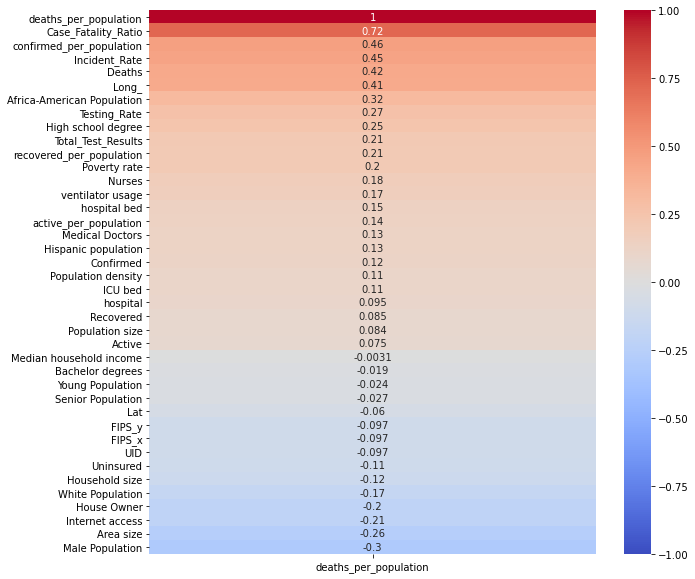

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(dmf.corr()[['deaths_per_population']].sort_values('deaths_per_population', ascending = False),
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1)

<AxesSubplot:>

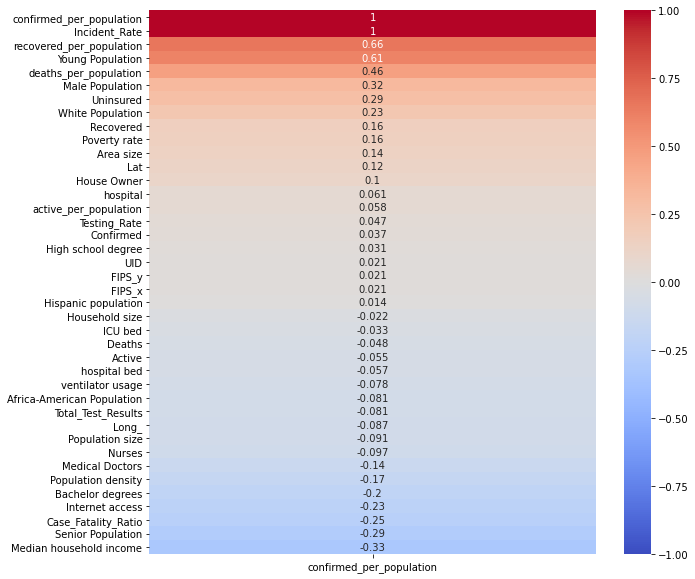

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(dmf.corr()[['confirmed_per_population']].sort_values('confirmed_per_population', ascending = False),
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1)

<AxesSubplot:>

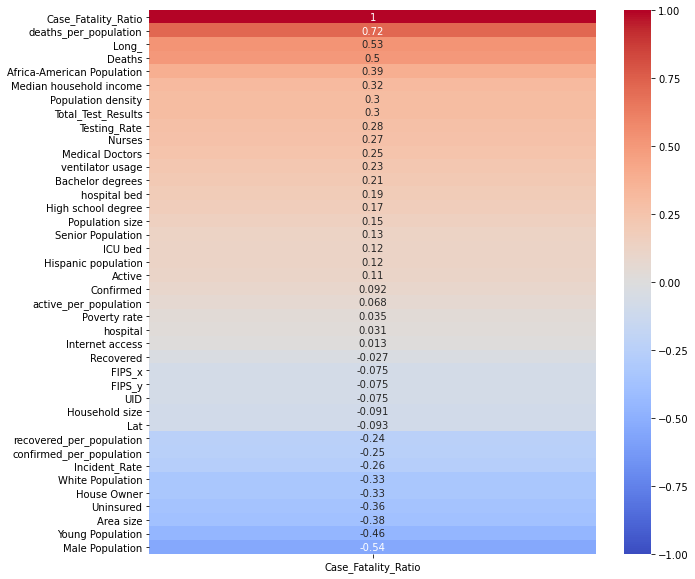

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(dmf.corr()[['Case_Fatality_Ratio']].sort_values('Case_Fatality_Ratio', ascending = False),
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1)

<AxesSubplot:>

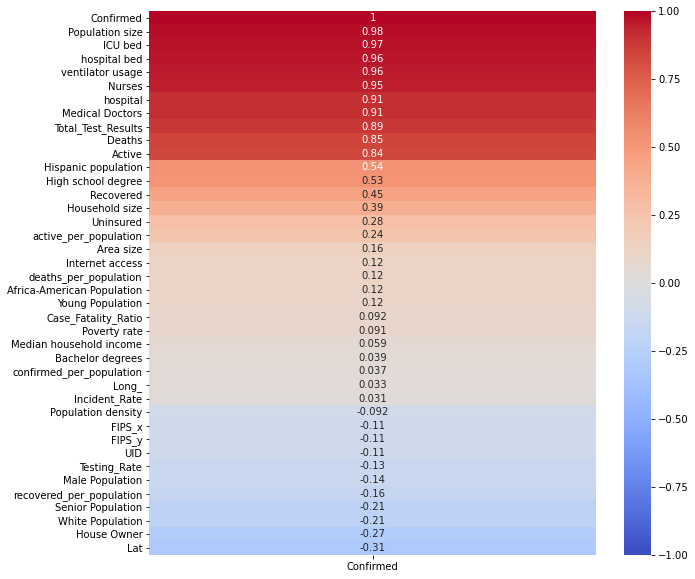

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(dmf.corr()[['Confirmed']].sort_values('Confirmed', ascending = False),
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1)

<AxesSubplot:>

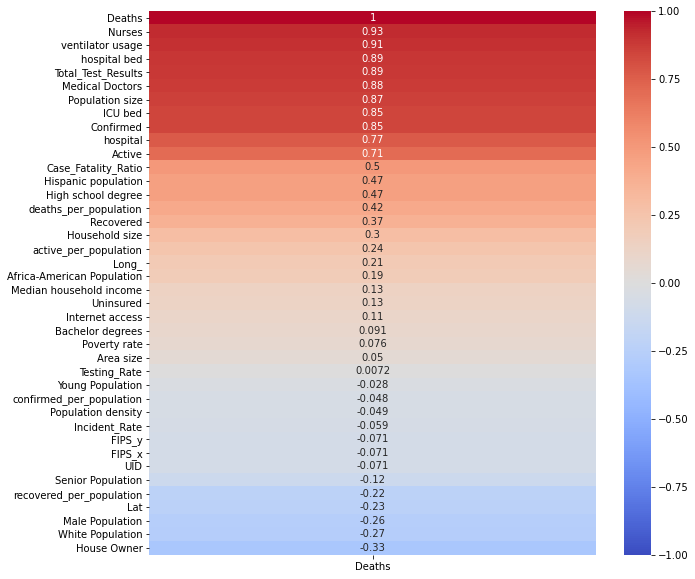

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(dmf.corr()[['Deaths']].sort_values('Deaths', ascending = False),
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1)

In [13]:
features = ['Population size', 'hospital', 'White Population', 'Africa-American Population',
       'Hispanic population', 'Household size']
X = dmf[features]
y = dmf['Deaths']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [15]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [16]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train)
print(lr.score(X_train_sc, y_train))
print(lr.score(X_test_sc, y_test))

0.7785810000383033
0.6612385301510577


In [17]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train)
print(lr.score(X_train_sc, y_train))
print(lr.score(X_test_sc, y_test))

0.7785810000383033
0.6612385301510577


In [18]:
lr.coef_

array([7547.91564615, -291.65234582,  167.23365373,  750.92398243,
        335.79948088, -342.17909228])

In [19]:
features = ['Case_Fatality_Ratio','Median household income', 'Poverty rate', 'White Population', 'Africa-American Population',
       'Hispanic population']
X = dmf[features]
y = dmf['deaths_per_population']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [20]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train)
print(lr.score(X_train_sc, y_train))
print(lr.score(X_test_sc, y_test))

0.6437203470250359
0.4184482084376405


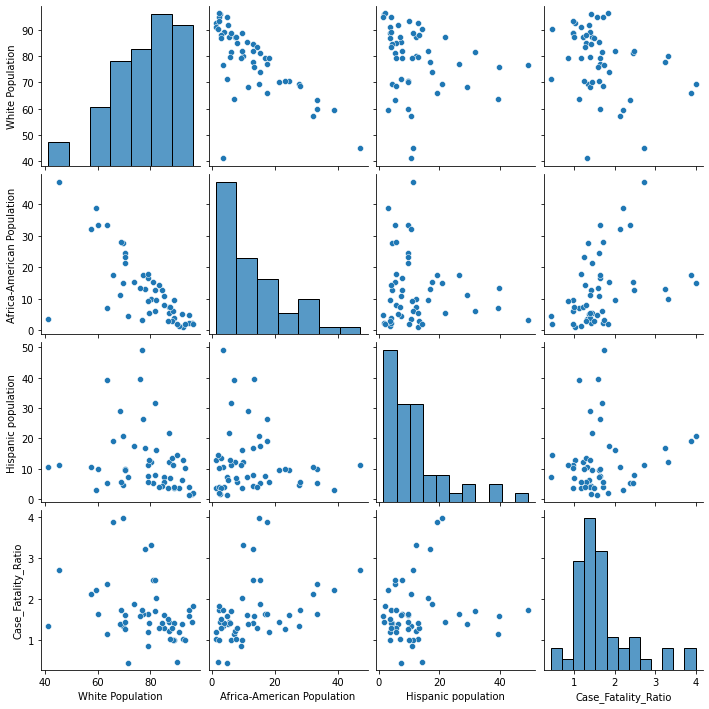

In [21]:
sns.pairplot(dmf[[ 'White Population', 'Africa-American Population',
       'Hispanic population', 'Case_Fatality_Ratio']])

In [22]:
dmf.sort_values('deaths_per_population', ascending = False)

,FIPS_x,Name,Postal Code,Area size,Population size,Population density,Senior Population,Young Population,Male Population,White Population,Africa-American Population,Hispanic population,Internet access,High school degree,Bachelor degrees,Median household income,Poverty rate,Uninsured,Household size,House Owner,hospital,hospital bed,ICU bed,ventilator usage,Nurses,Medical Doctors,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS_y,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,deaths_per_population,recovered_per_population,confirmed_per_population,active_per_population
30,34,New Jersey,NJ,22591,8882190,393.173830,16.6,18.0,48.9,69.5,15.1,20.9,89.5,9.7,25.1,85751,9.2,7.9,2.77,63.3,98,26385,1758,745,133029,113962,New Jersey,US,2021-01-01 05:30:27,40.2989,-74.5210,529027,19042,107337.0,402648.0,34.0,5374.350245,7735775.0,3.989023,84000034.0,USA,87093.104291,0.002144,0.012085,0.059560,0.045332
32,36,New York,NY,141297,19453561,137.678514,16.9,17.2,48.6,65.8,17.6,19.3,86.5,12.4,21.2,72108,13.0,5.2,2.71,53.5,224,54743,4230,1357,358901,407769,New York,US,2021-01-01 05:30:27,42.1657,-74.9481,978783,37983,102129.0,838671.0,36.0,5031.382172,25285060.0,3.880635,84000036.0,USA,129976.511755,0.001952,0.005250,0.050314,0.043111
21,25,Massachusetts,MA,27336,6892503,252.140145,17.0,16.1,48.5,80.2,9.9,12.4,89.1,8.7,24.7,85843,9.4,3.0,2.68,62.2,105,20056,1986,492,138481,155292,Massachusetts,US,2021-01-01 05:30:27,42.2302,-71.5301,375178,12423,261672.0,101083.0,25.0,5443.276557,10944699.0,3.311228,84000025.0,USA,158791.356348,0.001802,0.037965,0.054433,0.014666
34,38,North Dakota,ND,183108,762062,4.161817,15.8,19.6,51.0,89.0,3.9,4.0,84.4,6.5,21.5,64577,10.6,6.9,2.49,61.3,53,3317,516,66,16046,12751,North Dakota,US,2021-01-01 05:30:27,47.5289,-99.7840,92495,1299,89307.0,1889.0,38.0,12137.463881,1277930.0,1.396832,84000038.0,USA,167693.704712,0.001705,0.117191,0.121375,0.002479
41,46,South Dakota,SD,199729,884659,4.429297,17.4,20.5,50.8,86.7,3.0,3.7,85.2,7.9,20.6,59533,11.9,10.2,2.54,67.8,63,3232,392,90,18473,11874,South Dakota,US,2021-01-01 05:30:27,44.2998,-99.4388,99164,1488,91980.0,5696.0,46.0,11209.290811,372640.0,1.500545,84000046.0,USA,42122.444919,0.001682,0.103972,0.112093,0.006439
6,9,Connecticut,CT,14357,3565287,248.330919,17.6,16.6,48.9,77.8,13.2,16.9,88.8,9.3,22.0,78833,10.0,5.9,2.65,65.0,46,8123,966,193,67924,58009,Connecticut,US,2021-01-01 05:30:27,41.5978,-72.7554,185708,5995,9800.0,169913.0,9.0,5208.781229,4320693.0,3.228186,84000009.0,USA,121187.803394,0.001681,0.002749,0.052088,0.047658
39,44,Rhode Island,RI,4001,1059361,264.774056,17.7,15.7,48.8,82.0,9.6,16.3,87.8,10.7,20.9,71169,10.8,4.1,2.69,61.7,15,3413,375,64,25014,18028,Rhode Island,US,2021-01-01 05:30:27,41.6809,-71.5118,87949,1777,5381.0,80791.0,44.0,8302.080216,1974498.0,2.020489,84000044.0,USA,186385.755186,0.001677,0.005079,0.083021,0.076264
18,22,Louisiana,LA,135659,4648794,34.268231,16.0,19.5,48.8,63.5,33.4,5.4,80.7,14.0,16.0,51073,19.0,8.9,2.67,66.5,215,21055,2212,463,69699,63967,Louisiana,US,2021-01-01 05:30:27,31.1695,-91.8678,315275,7488,263712.0,44075.0,22.0,6781.866437,4214182.0,2.375069,84000022.0,USA,90651.080689,0.001611,0.056727,0.067819,0.009481
24,28,Mississippi,MS,125438,2976149,23.726056,16.4,19.5,48.2,59.4,38.9,3.0,77.0,14.7,13.7,45792,19.6,13.0,2.67,67.3,114,15148,1069,307,50103,28705,Mississippi,US,2021-01-01 05:30:27,32.7416,-89.6787,215811,4787,167263.0,43761.0,28.0,7251.350655,1343469.0,2.218145,84000028.0,USA,45141.187488,0.001608,0.056201,0.072514,0.014704
13,17,Illinois,IL,149995,12671821,84.481623,16.1,18.3,49.1,73.8,15.4,17.5,86.2,10.2,21.7,69187,11.5,7.4,2.70,66.0,214,37883,3743,929,207001,170660,Illinois,US,2021-01-01 05:30:27,40.3495,-88.9861,963389,17978,0.0,945411.0,17.0,7602.608970,13277443.0,1.866121,84000017.0,USA,104779.281526,0.001419,0.000000,0.076026,0.074607


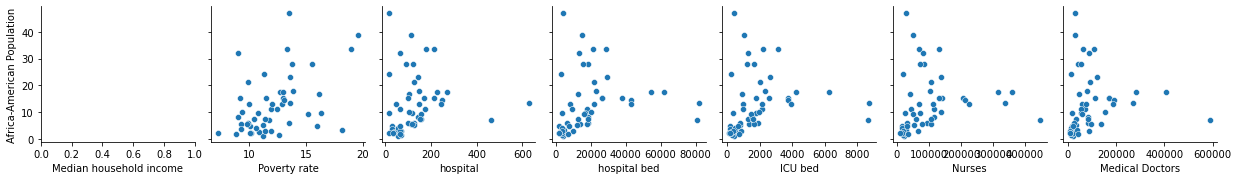

In [23]:
sns.pairplot(data=dmf,
                  y_vars=['Africa-American Population'],
                  x_vars=['Median household income', 'Poverty rate', 'hospital',
       'hospital bed', 'ICU bed', 'Nurses',
       'Medical Doctors'])

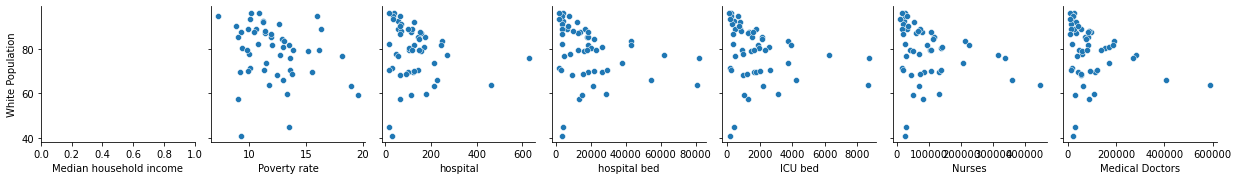

In [24]:
sns.pairplot(data=dmf,
                  y_vars=['White Population'],
                  x_vars=['Median household income', 'Poverty rate', 'hospital',
       'hospital bed', 'ICU bed', 'Nurses',
       'Medical Doctors'])

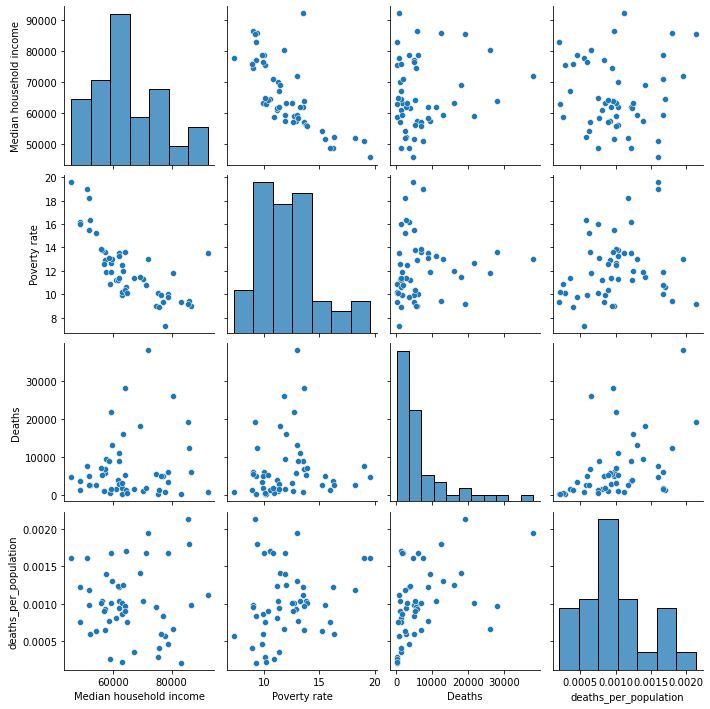

In [25]:
sns.pairplot(dmf[[ 'Median household income', 'Poverty rate', 'Deaths', 'deaths_per_population']])

In [26]:
dmf['Case_Fatality_Ratio'].describe()

count    51.000000
mean      1.660667
std       0.738485
min       0.438428
25%       1.265137
50%       1.440899
75%       1.784340
max       3.989023
Name: Case_Fatality_Ratio, dtype: float64

In [27]:
dmf['Case_Fatality_Ratio'].sort_values(ascending=False) #2.0

30    3.989023
32    3.880635
21    3.311228
6     3.228186
8     2.711935
38    2.470909
22    2.462634
18    2.375069
24    2.218145
20    2.130759
39    2.020489
13    1.866121
45    1.834862
31    1.733817
29    1.723903
40    1.722237
2     1.703937
10    1.640628
9     1.637781
3     1.632776
14    1.615492
7     1.611668
43    1.582058
48    1.567957
41    1.500545
5     1.440899
46    1.439425
19    1.433825
25    1.411485
47    1.402623
34    1.396832
28    1.389216
15    1.381198
0     1.336283
11    1.324442
37    1.296649
23    1.295924
35    1.279591
33    1.250683
16    1.213627
26    1.178346
42    1.177058
4     1.130376
12    1.017884
49    1.007229
27    0.989820
17    0.988837
50    0.986287
36    0.855515
44    0.458765
1     0.438428
Name: Case_Fatality_Ratio, dtype: float64

In [28]:
dmf['top_25_cfr']=(dmf['Case_Fatality_Ratio'] > 1.784340).astype(int)

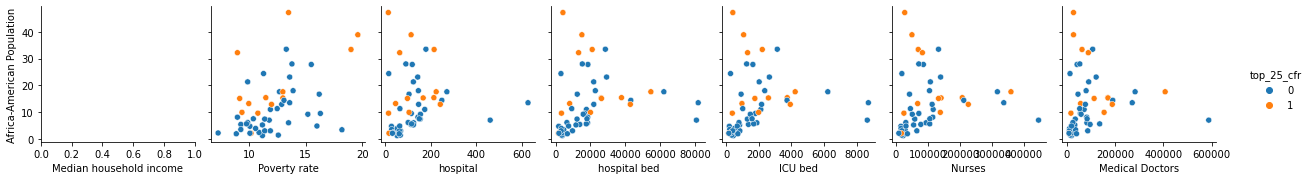

In [29]:
sns.pairplot(data=dmf,
                  y_vars=['Africa-American Population'],
                  x_vars=['Median household income', 'Poverty rate', 'hospital',
       'hospital bed', 'ICU bed', 'Nurses',
       'Medical Doctors'], hue='top_25_cfr')

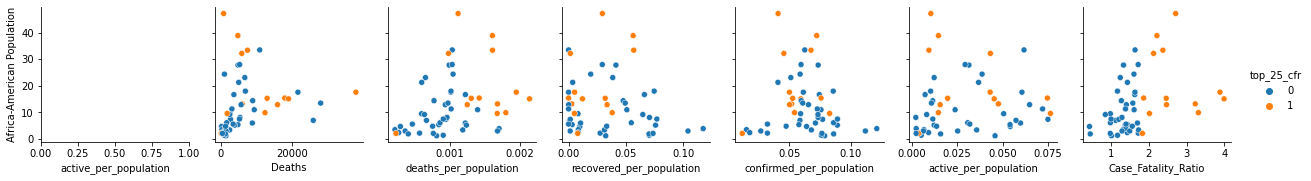

In [30]:
sns.pairplot(data=dmf,
                  y_vars=['Africa-American Population'],
                  x_vars=['active_per_population','Deaths','deaths_per_population',
       'recovered_per_population', 'confirmed_per_population',
       'active_per_population', 'Case_Fatality_Ratio'], hue='top_25_cfr')

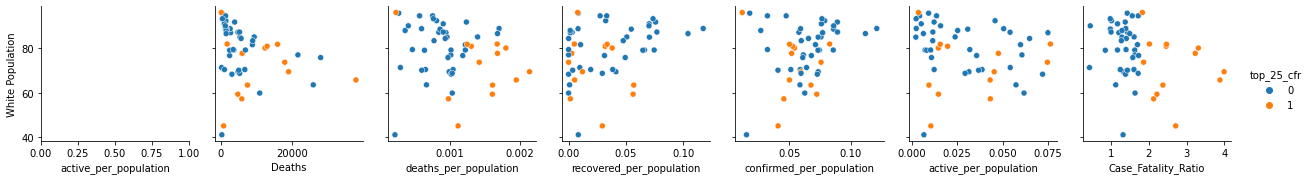

In [31]:
sns.pairplot(data=dmf,
                  y_vars=['White Population'],
                  x_vars=['active_per_population','Deaths','deaths_per_population',
       'recovered_per_population', 'confirmed_per_population',
       'active_per_population', 'Case_Fatality_Ratio'], hue='top_25_cfr')

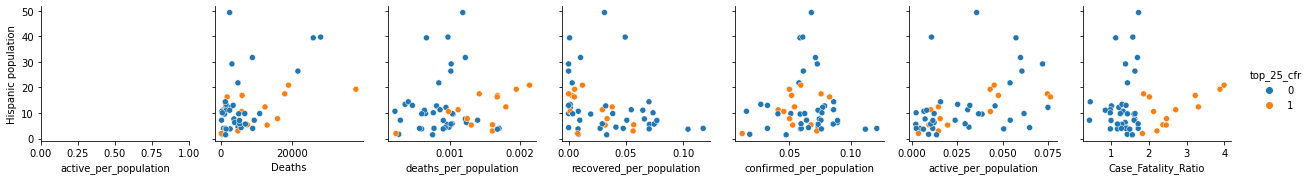

In [32]:
sns.pairplot(data=dmf,
                  y_vars=['Hispanic population'],
                  x_vars=['active_per_population','Deaths','deaths_per_population',
       'recovered_per_population', 'confirmed_per_population',
       'active_per_population', 'Case_Fatality_Ratio'], hue='top_25_cfr')

In [33]:
bleh=pd.DataFrame(dmf[['Median household income', 'Poverty rate', 'hospital',
       'hospital bed', 'ICU bed', 'Nurses', 'White Population', 'Africa-American Population',
       'Hispanic population', 'Case_Fatality_Ratio', 'top_25_cfr']])

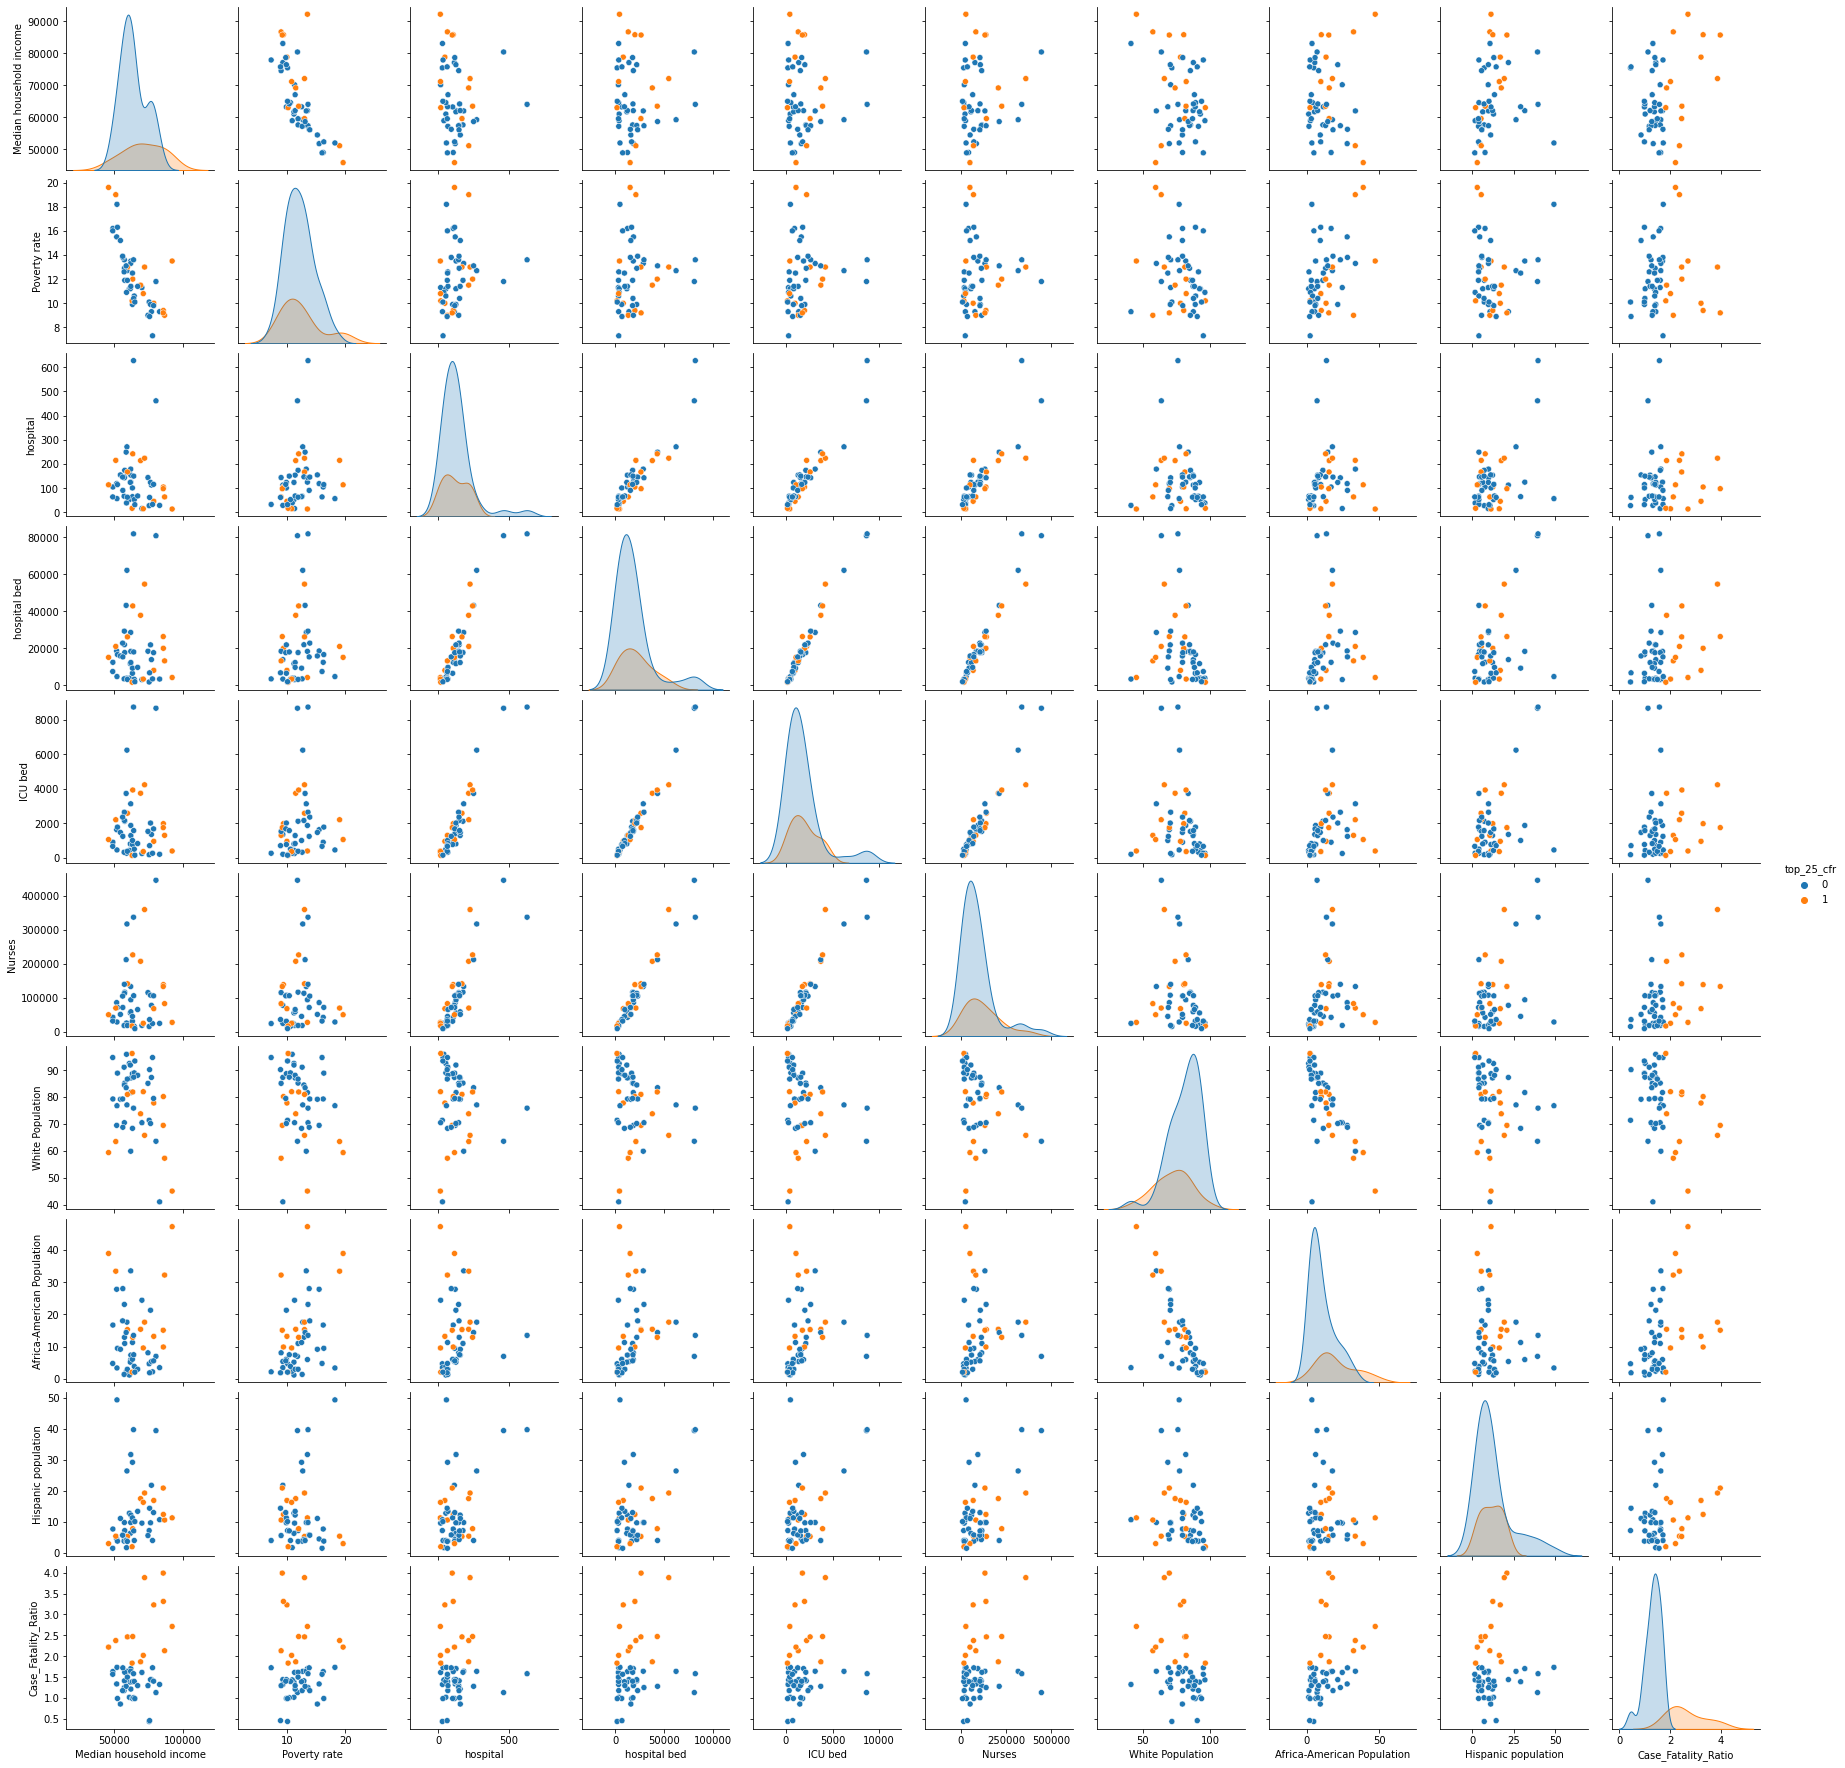

In [34]:
sns.pairplot(bleh, hue='top_25_cfr');

In [35]:
blah=pd.DataFrame(dmf[['Median household income', 'Poverty rate', 'hospital', 
                       'White Population', 'Africa-American Population',
                       'Hispanic population', 'Deaths',
                       'Case_Fatality_Ratio', 'deaths_per_population',
                      'confirmed_per_population', 'Population size']])

In [36]:
dmf.head()

,FIPS_x,Name,Postal Code,Area size,Population size,Population density,Senior Population,Young Population,Male Population,White Population,Africa-American Population,Hispanic population,Internet access,High school degree,Bachelor degrees,Median household income,Poverty rate,Uninsured,Household size,House Owner,hospital,hospital bed,ICU bed,ventilator usage,Nurses,Medical Doctors,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS_y,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,deaths_per_population,recovered_per_population,confirmed_per_population,active_per_population,top_25_cfr
0,1,Alabama,AL,135767,4903185,36.114704,17.4,18.3,48.3,69.5,27.8,4.5,81.9,12.9,16.3,51734,15.5,9.7,2.60,68.8,119,18611,1637,383,85746,43429,Alabama,US,2021-01-01 05:30:27,32.3182,-86.9023,361226,4827,202137.0,154262.0,1.0,7367.170523,1874000.0,1.336283,84000001.0,USA,38220.054923,0.000984,0.041226,0.073672,0.031462,0
1,2,Alaska,AK,1723337,731545,0.424493,12.4,21.0,52.0,71.4,4.7,7.2,88.0,6.4,18.5,75463,10.1,12.2,2.90,64.7,28,1832,193,41,15487,18418,Alaska,US,2021-01-01 05:30:27,61.3707,-152.4044,46986,206,7165.0,39615.0,2.0,6422.844801,1275750.0,0.438428,84000002.0,USA,174391.185778,0.000282,0.009794,0.064228,0.054153,0
2,4,Arizona,AZ,295234,7278717,24.654061,18.0,18.7,49.7,81.7,6.0,31.7,87.4,12.4,18.8,62055,13.5,11.3,2.71,65.3,125,18388,1882,427,93928,84130,Arizona,US,2021-01-01 05:30:27,33.7298,-111.4312,520207,8864,75981.0,435362.0,4.0,7146.960103,2834752.0,1.703937,84000004.0,USA,38945.764755,0.001218,0.010439,0.071470,0.059813,0
3,5,Arkansas,AR,137732,3017804,21.910696,17.4,19.2,48.9,79.3,16.7,7.7,80.1,12.5,15.1,48952,16.2,9.1,2.59,65.5,105,12473,914,261,42487,47343,Arkansas,US,2021-01-01 05:30:27,34.9697,-92.3731,225138,3676,199247.0,22215.0,5.0,7460.325455,2051488.0,1.632776,84000005.0,USA,67979.497674,0.001218,0.066024,0.074603,0.007361,0
4,6,California,CA,423967,39512223,93.196459,14.8,18.7,49.7,63.6,7.0,39.4,90.0,16.0,21.9,80440,11.8,7.7,3.02,54.9,461,80893,8652,1986,444964,588052,California,US,2021-01-01 05:30:27,36.1162,-119.6816,2325599,25986,34503.0,2265110.0,6.0,5798.223502,32855482.0,1.130376,84000006.0,USA,83152.704418,0.000658,0.000873,0.058858,0.057327,0


In [37]:
ss = StandardScaler()
X_blah = ss.fit_transform(blah)

In [38]:
dbscan = DBSCAN(eps=2.1, min_samples=3)

In [39]:
dbscan.fit(X_blah)

DBSCAN(eps=2.1, min_samples=3)

In [40]:
blah['cluster'] = dbscan.labels_

In [41]:
blah.groupby('cluster').mean().T.drop(columns=-1)

cluster,0,1
Median household income,6.263212e+04,8.347567e+04
Poverty rate,1.200882e+01,9.533333e+00
hospital,1.127647e+02,8.300000e+01
White Population,8.300588e+01,7.583333e+01
Africa-American Population,1.085882e+01,1.273333e+01
Hispanic population,8.102941e+00,1.673333e+01
Deaths,4.650206e+03,1.248667e+04
Case_Fatality_Ratio,1.370678e+00,3.509479e+00
deaths_per_population,8.849194e-04,1.875908e-03
confirmed_per_population,6.614094e-02,5.536033e-02


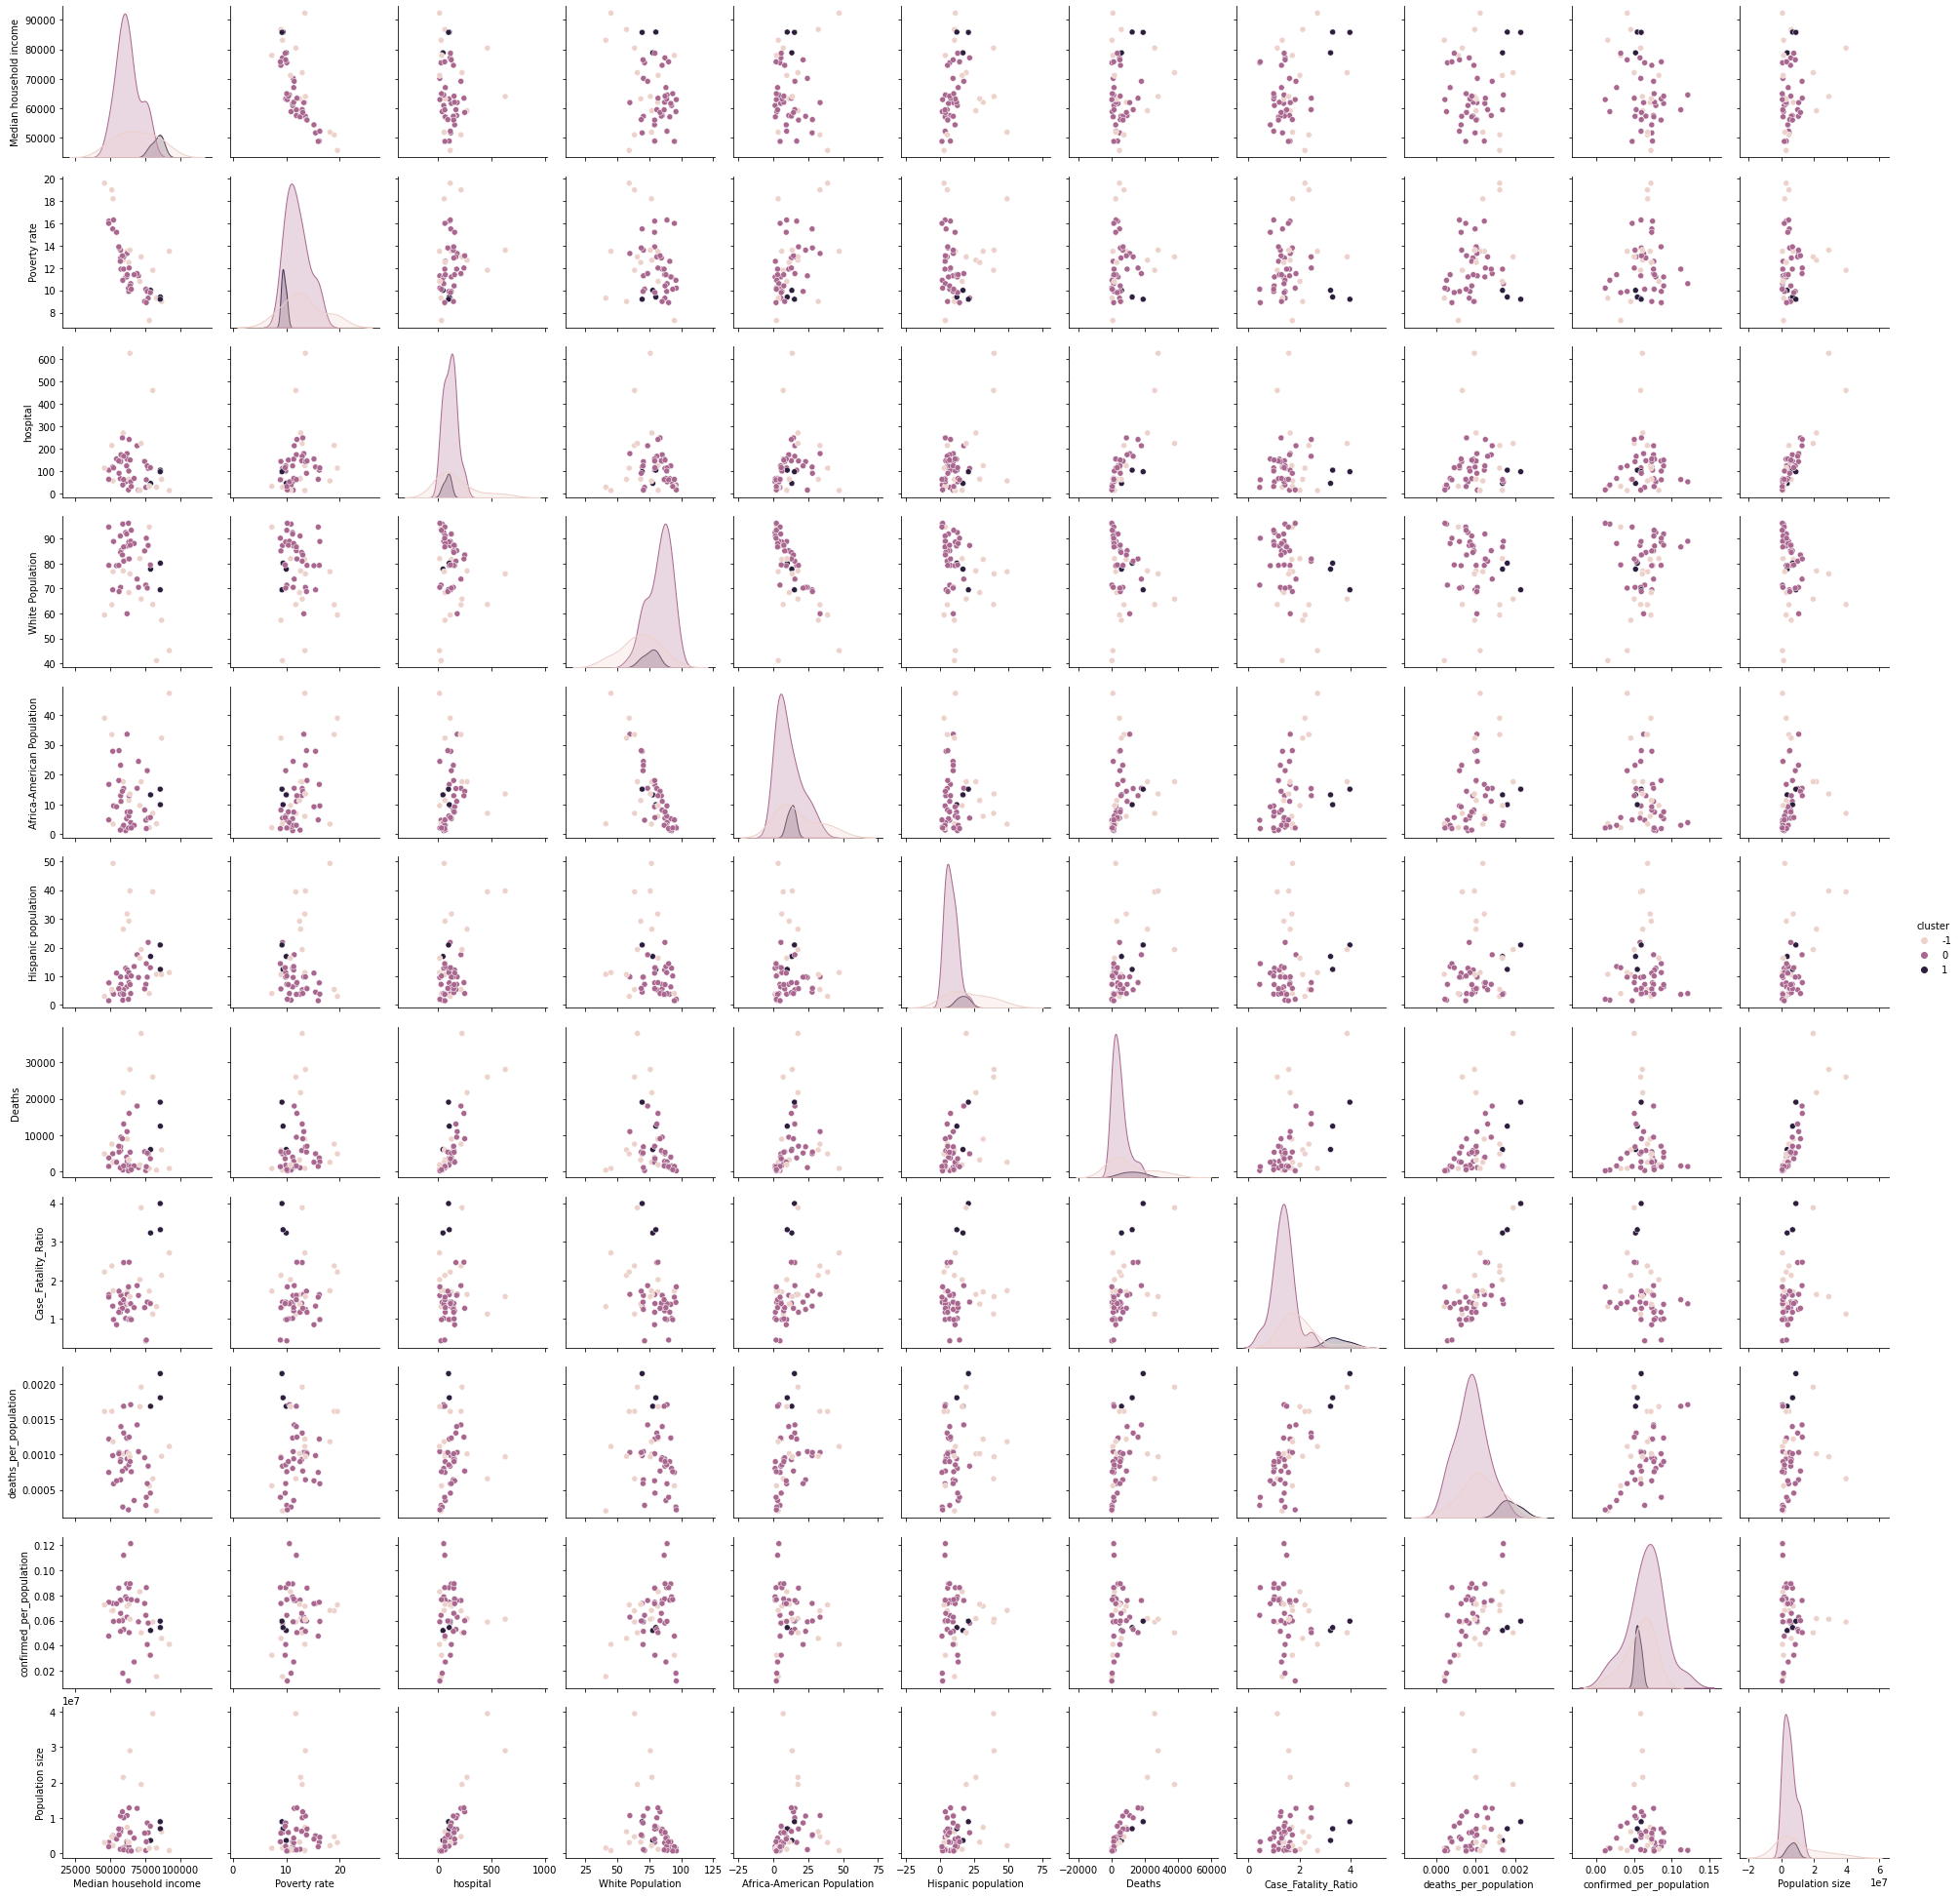

In [42]:
sns.pairplot(blah, hue='cluster');